<a href="https://colab.research.google.com/github/LucasLucena001/k_Means_MKT01/blob/main/K_means_MKT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')


In [ ]:
# Calcular a métrica de Valor (TotalSpent)
data['TotalSpent'] = data['Quantity'] * data['UnitPrice']

# Converter InvoiceDate para datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Definir a data de snapshot para cálculo da recência
snapshot_date = max(data['InvoiceDate']) + pd.Timedelta(days=1)

# Criar DataFrame RFM
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSpent': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpent': 'MonetaryValue'
}).reset_index()

print(rfm.head())

   CustomerID  Recency  Frequency  MonetaryValue
0     12346.0      326          2           0.00
1     12347.0        2        182        4310.00
2     12348.0       75         31        1797.24
3     12349.0       19         73        1757.55
4     12350.0      310         17         334.40


In [ ]:
# Remover outliers utilizando IQR
Q1 = rfm[['Recency', 'Frequency', 'MonetaryValue']].quantile(0.25)
Q3 = rfm[['Recency', 'Frequency', 'MonetaryValue']].quantile(0.75)
IQR = Q3 - Q1

# Use boolean indexing to filter outliers for each column individually
rfm_filtered = rfm[~((rfm['Recency'] < (Q1['Recency'] - 1.5 * IQR['Recency'])) | (rfm['Recency'] > (Q3['Recency'] + 1.5 * IQR['Recency'])))]
rfm_filtered = rfm_filtered[~((rfm_filtered['Frequency'] < (Q1['Frequency'] - 1.5 * IQR['Frequency'])) | (rfm_filtered['Frequency'] > (Q3['Frequency'] + 1.5 * IQR['Frequency'])))]
rfm_filtered = rfm_filtered[~((rfm_filtered['MonetaryValue'] < (Q1['MonetaryValue'] - 1.5 * IQR['MonetaryValue'])) | (rfm_filtered['MonetaryValue'] > (Q3['MonetaryValue'] + 1.5 * IQR['MonetaryValue'])))]

rfm_filtered = rfm_filtered.reset_index(drop=True)

# Verificar a quantidade de linhas após a remoção de outliers
print(rfm_filtered.shape)

(3658, 4)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency', 'Frequency', 'MonetaryValue']])

# Verificar os dados normalizados
print(rfm_scaled[:5])


[[ 2.58373034 -1.02886055 -1.06882703]
 [-0.18337185 -0.43762647  1.24864008]
 [-0.8007333   0.41864358  1.19746146]
 [ 2.40734136 -0.72304982 -0.63763197]
 [-0.61332     0.86716598  0.92391565]]


Para n_clusters = 2, o Silhouette Score é 0.4295
Para n_clusters = 3, o Silhouette Score é 0.4492
Para n_clusters = 4, o Silhouette Score é 0.4031
Para n_clusters = 5, o Silhouette Score é 0.4086
Para n_clusters = 6, o Silhouette Score é 0.3628
Para n_clusters = 7, o Silhouette Score é 0.3393
Para n_clusters = 8, o Silhouette Score é 0.3460
Para n_clusters = 9, o Silhouette Score é 0.3530
Para n_clusters = 10, o Silhouette Score é 0.3596


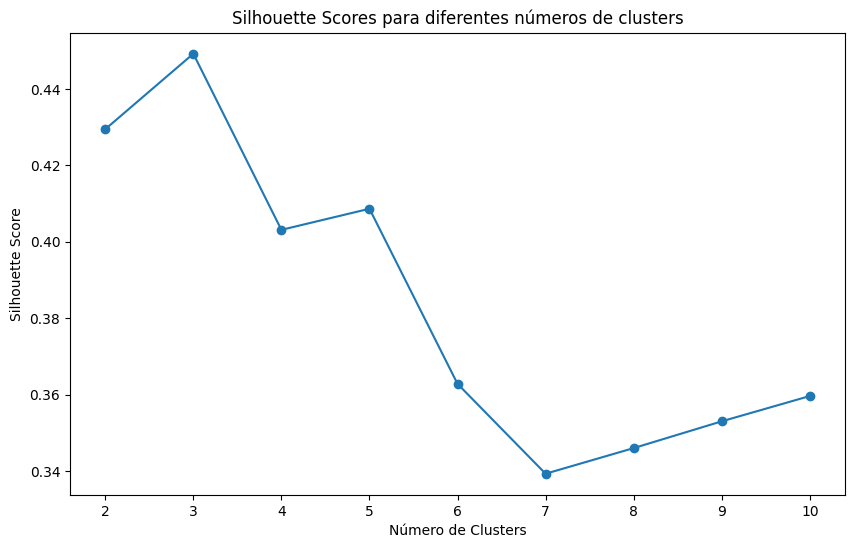

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Lista para armazenar os scores
silhouette_scores = []

# Testar de 2 a 10 clusters
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Para n_clusters = {n_clusters}, o Silhouette Score é {silhouette_avg:.4f}')

# Plotar os Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores para diferentes números de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Melhor número de clusters
best_n_clusters = 3

# Implementar o KMeans com o número ideal de clusters
kmeans = KMeans(n_clusters=best_n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(rfm_scaled)

# Adicionar os clusters ao DataFrame filtrado
rfm_filtered['Cluster'] = kmeans.labels_

print(rfm_filtered.head())


   CustomerID  Recency  Frequency  MonetaryValue  Cluster
0     12346.0      326          2           0.00        1
1     12348.0       75         31        1797.24        0
2     12349.0       19         73        1757.55        2
3     12350.0      310         17         334.40        1
4     12352.0       36         95        1545.41        2


In [ ]:
cluster_summary = rfm_filtered.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

print(cluster_summary)

            Recency   Frequency  MonetaryValue  CustomerCount
Cluster                                                      
0         48.023136   36.388175     583.166320           1945
1        229.107726   23.841132     373.715702            919
2         39.345088  124.979849    1957.679485            794


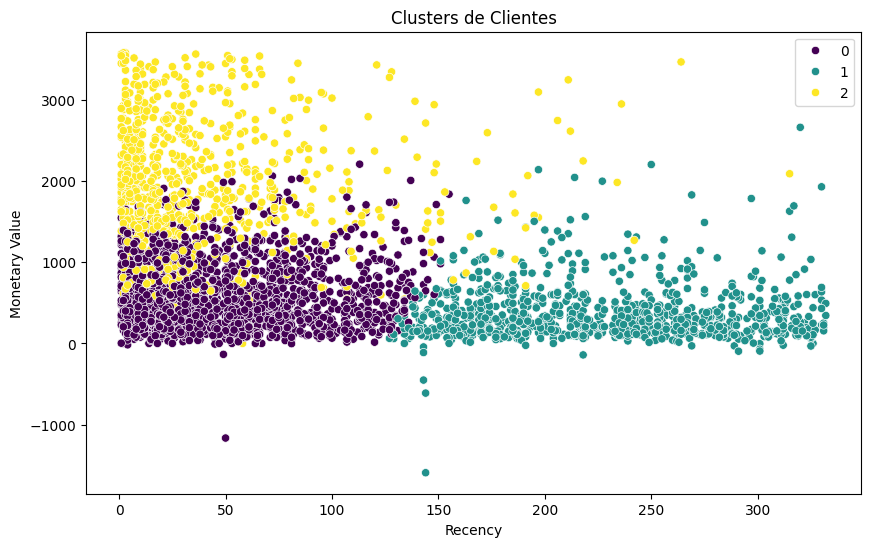

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='MonetaryValue', hue='Cluster', data=rfm_filtered, palette='viridis')
plt.title('Clusters de Clientes')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()

In [ ]:
# prompt: Descrever o Perfil de Compras dos Clientes de Cada Cluster
# Cluster 0:
# Recência média: x dias
# Frequência média: y compras
# Valor monetário médio: z
# Cluster 1:
# Recência média: x dias
# Frequência média: y compras
# Valor monetário médio: z
# Cluster 2:
# Recência média: x dias
# Frequência média: y compras
# Valor monetário médio: z

# Cluster 0
cluster_0 = rfm_filtered[rfm_filtered['Cluster'] == 0]
recency_0 = cluster_0['Recency'].mean()
frequency_0 = cluster_0['Frequency'].mean()
monetary_value_0 = cluster_0['MonetaryValue'].mean()

# Cluster 1
cluster_1 = rfm_filtered[rfm_filtered['Cluster'] == 1]
recency_1 = cluster_1['Recency'].mean()
frequency_1 = cluster_1['Frequency'].mean()
monetary_value_1 = cluster_1['MonetaryValue'].mean()

# Cluster 2
cluster_2 = rfm_filtered[rfm_filtered['Cluster'] == 2]
recency_2 = cluster_2['Recency'].mean()
frequency_2 = cluster_2['Frequency'].mean()
monetary_value_2 = cluster_2['MonetaryValue'].mean()

# Print the cluster profiles
print("Cluster 0:")
print(f"  - Recência média: {recency_0:.2f} dias")
print(f"  - Frequência média: {frequency_0:.2f} compras")
print(f"  - Valor monetário médio: R${monetary_value_0:.2f}")

print("Cluster 1:")
print(f"  - Recência média: {recency_1:.2f} dias")
print(f"  - Frequência média: {frequency_1:.2f} compras")
print(f"  - Valor monetário médio: R${monetary_value_1:.2f}")

print("Cluster 2:")
print(f"  - Recência média: {recency_2:.2f} dias")
print(f"  - Frequência média: {frequency_2:.2f} compras")
print(f"  - Valor monetário médio: R${monetary_value_2:.2f}")


Cluster 0:
  - Recência média: 48.02 dias
  - Frequência média: 36.39 compras
  - Valor monetário médio: R$583.17
Cluster 1:
  - Recência média: 229.11 dias
  - Frequência média: 23.84 compras
  - Valor monetário médio: R$373.72
Cluster 2:
  - Recência média: 39.35 dias
  - Frequência média: 124.98 compras
  - Valor monetário médio: R$1957.68



# Análise dos Clusters de Clientes

Com base nos dados fornecidos, podemos dividir os clientes em três clusters distintos, cada um com características próprias em termos de recência, frequência de compras e valor monetário médio. Vamos analisar cada um desses clusters e sugerir ações específicas para a empresa de e-commerce.

# Cluster 0:


Recência média: 48.02 dias

Frequência média: 36.39 compras

Valor monetário médio: R$583.17

Perfil dos Clientes:
Os clientes deste cluster tendem a fazer compras de forma relativamente frequente e recente, com uma média de 36.39 compras e uma recência média de 48.02 dias. No entanto, o valor monetário médio gasto é moderado, em torno de R$583.17.


Sugestões de Ações:

Programas de Fidelidade: Implementar programas de fidelidade que ofereçam recompensas por compras repetidas pode incentivar esses clientes a aumentar a frequência e o valor de suas compras.

Promoções Especiais: Oferecer descontos personalizados e promoções exclusivas para estimular compras adicionais.

Newsletters com Produtos Recomendados: Enviar newsletters com recomendações de produtos baseadas em suas compras anteriores para aumentar o engajamento e a retenção.



# Cluster 1:

Recência média: 229.11 dias

Frequência média: 23.84 compras

Valor monetário médio: R$373.72

Perfil dos Clientes:
Este cluster é composto por clientes que não compraram recentemente, com uma recência média de 229.11 dias. Eles também têm uma frequência de compras mais baixa, com uma média de 23.84 compras, e gastam menos, com um valor monetário médio de R$373.72.

Sugestões de Ações:

Campanhas de Reativação: Enviar campanhas de reativação com ofertas especiais, como descontos exclusivos ou frete grátis, para incentivar esses clientes a voltarem a comprar.

Incentivos para Compras Futuras: Oferecer descontos progressivos para compras futuras pode estimular esses clientes a aumentar a frequência de suas compras.
Pesquisas de Satisfação: Realizar pesquisas de satisfação para entender por que esses clientes diminuíram suas compras e como a empresa pode melhor atender às suas necessidades.


# Cluster 2:

Recência média: 39.35 dias

Frequência média: 124.98 compras

Valor monetário médio: R$1957.68

Perfil dos Clientes:
Clientes deste cluster são os mais valiosos para a empresa. Eles têm uma recência muito baixa (média de 39.35 dias), indicativa de compras recentes, e compram com alta frequência, com uma média de 124.98 compras. Além disso, eles gastam significativamente mais, com um valor monetário médio de R$1957.68.

Sugestões de Ações:

Programas de Reconhecimento e Exclusividade: Implementar programas de reconhecimento para esses clientes, oferecendo benefícios exclusivos, como acesso antecipado a novos produtos, eventos VIP e descontos especiais.
Manter o Engajamento: Continuar a engajar esses clientes com campanhas personalizadas que destacam novos produtos e ofertas que correspondam às suas preferências de compra.
Serviço Premium: Oferecer serviços premium, como atendimento ao cliente dedicado ou opções de entrega prioritária, para reforçar a fidelidade desses clientes de alto valor.
Conclusão
A análise dos clusters permite à empresa de e-commerce entender melhor o comportamento de seus clientes e adaptar suas estratégias de marketing de acordo com as características específicas de cada grupo
